In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yt
import pickle
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse

C:\Users\Sneha\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
end_date = datetime.now().strftime('%Y-%m-%d')
df=yt.download('BTC-USD','2014-01-01',end_date, interval = '1d')

[*********************100%%**********************]  1 of 1 completed


C:\Users\Sneha\anaconda3\Lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [3]:
df

Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2024-02-27  54519.363281  57537.839844  54484.199219  57085.371094   
2024-02-28  57071.097656  63913.132812  56738.425781  62504.789062   
2024-02-29  62499.183594  63585.644531  60498.730469  61198.382812   
2024-03-01  61168.062500  63155.101562  60802.527344  62440.632812   
2024-03-02  62431.652344  62458.699219  61657.289062  62029.847656   

               Adj Close       Volume  
Date                                   
2014-09-17    457.334015     21056800  
2014-09-18    424.440002     34483200  
2014-09-19    394.795990     37919700  
2014-09-20    408.903992     36863600  
2014-09-21    398.821014     26580100  
...                  ...          ...  
2024-02-27  57085.371094  49756832031  
2024-02-28  62504.789062  83239156760  
2024-02-29  61198.382812  65496611844  
2024-03-01  62440.632812  40186368423  
2024-03-02  62029.847656  23888473685  

[3455 rows x 6 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3455 entries, 2014-09-17 to 2024-03-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3455 non-null   float64
 1   High       3455 non-null   float64
 2   Low        3455 non-null   float64
 3   Close      3455 non-null   float64
 4   Adj Close  3455 non-null   float64
 5   Volume     3455 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 188.9 KB


In [5]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
df['Mean'] = (df['Low'] + df['High'])/2

In [7]:
df=df.dropna()

In [8]:
data=df.copy()

In [9]:
data['Actual'] = data['Mean'].shift()

In [10]:
data=data.dropna()

In [11]:
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

In [12]:
data.corr()

Open      High       Low     Close  Adj Close    Volume  \
Open       1.000000  0.999492  0.999151  0.998851   0.998851  0.672921   
High       0.999492  1.000000  0.998984  0.999488   0.999488  0.678528   
Low        0.999151  0.998984  1.000000  0.999384   0.999384  0.663076   
Close      0.998851  0.999488  0.999384  1.000000   1.000000  0.671667   
Adj Close  0.998851  0.999488  0.999384  1.000000   1.000000  0.671667   
Volume     0.672921  0.678528  0.663076  0.671667   0.671667  1.000000   
Mean       0.999579  0.999759  0.999733  0.999691   0.999691  0.671165   
Actual     0.999691  0.999179  0.998808  0.998541   0.998541  0.673187   
Date       0.776817  0.774289  0.780753  0.777050   0.777050  0.624173   

               Mean    Actual      Date  
Open       0.999579  0.999691  0.776817  
High       0.999759  0.999179  0.774289  
Low        0.999733  0.998808  0.780753  
Close      0.999691  0.998541  0.777050  
Adj Close  0.999691  0.998541  0.777050  
Volume     0.671165  0.673187  0.624173  
Mean       1.000000  0.999252  0.777638  
Actual     0.999252  1.000000  0.777476  
Date       0.777638  0.777476  1.000000

<Axes: >

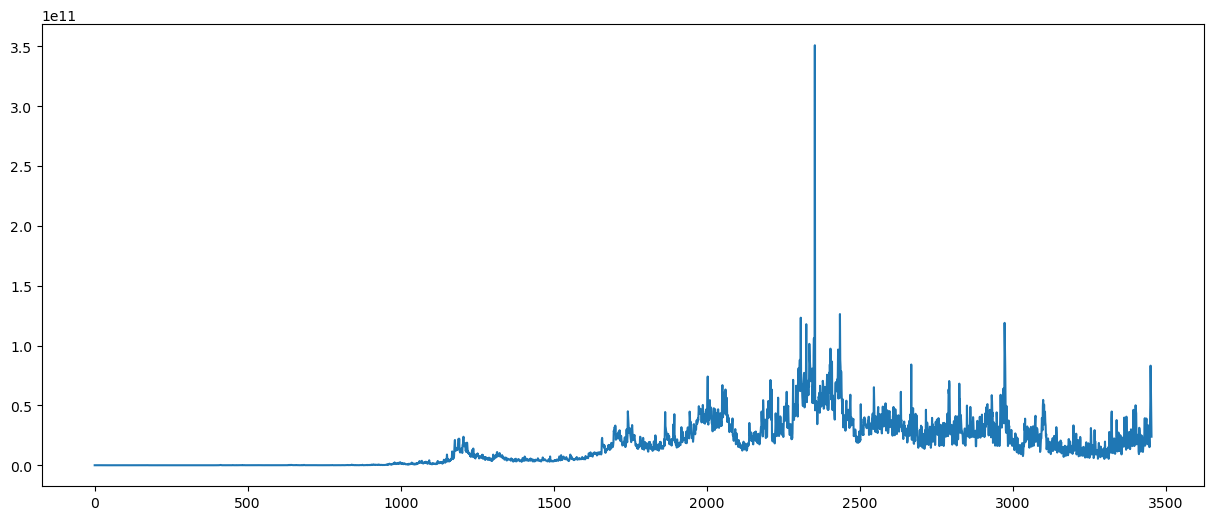

In [13]:
data['Volume'].plot(figsize=(15,6))

FB PROPHET

In [14]:
fb=data[['Date','Volume']]

In [15]:
fb.rename(columns = {'Volume':'y','Date':'ds'},inplace = True)

C:\Users\Sneha\AppData\Local\Temp\ipykernel_19356\3335913894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fb.rename(columns = {'Volume':'y','Date':'ds'},inplace = True)


In [16]:
fb

ds            y
0    2014-09-18     34483200
1    2014-09-19     37919700
2    2014-09-20     36863600
3    2014-09-21     26580100
4    2014-09-22     24127600
...         ...          ...
3449 2024-02-27  49756832031
3450 2024-02-28  83239156760
3451 2024-02-29  65496611844
3452 2024-03-01  40186368423
3453 2024-03-02  23888473685

[3454 rows x 2 columns]

In [17]:
 fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3454 non-null   datetime64[ns]
 1   y       3454 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 54.1 KB


<Axes: xlabel='ds'>

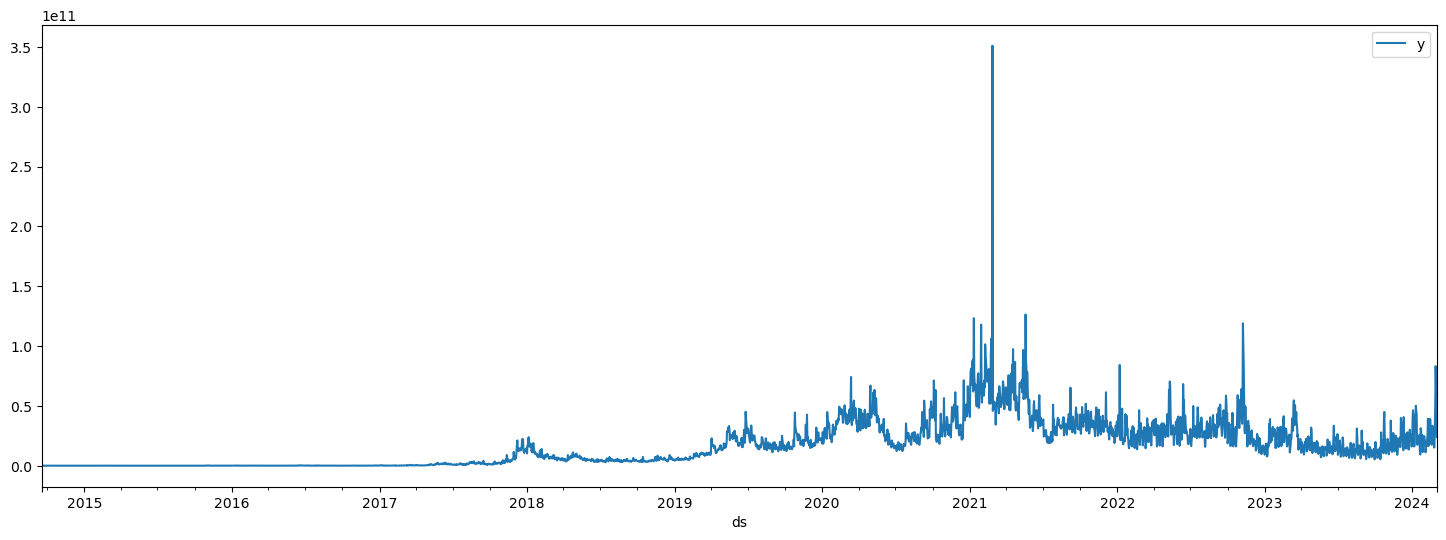

In [18]:
fb.plot(x='ds',y='y',figsize=(18,6))

In [19]:
train = fb.iloc[:-365,:]
train.shape

(3089, 2)

In [20]:
test = fb.iloc[-365:]
test.shape

(365, 2)

In [21]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:39 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
forecast.tail()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
3449 2024-02-27  1.707800e+10 -6.239570e+09  4.658599e+10 -8.398034e+09   
3450 2024-02-28  1.705637e+10 -5.775464e+09  4.735292e+10 -8.492143e+09   
3451 2024-02-29  1.703473e+10 -8.312286e+09  4.474742e+10 -8.556902e+09   
3452 2024-03-01  1.701310e+10 -7.758929e+09  4.696610e+10 -8.621661e+09   
3453 2024-03-02  1.699146e+10 -1.255196e+10  4.277464e+10 -8.683126e+09   

       trend_upper  additive_terms  additive_terms_lower  \
3449  3.989970e+10    3.475530e+09          3.475530e+09   
3450  3.995143e+10    3.647942e+09          3.647942e+09   
3451  4.001872e+10    3.223386e+09          3.223386e+09   
3452  4.015745e+10    3.273074e+09          3.273074e+09   
3453  4.032732e+10   -6.667389e+08         -6.667389e+08   

      additive_terms_upper        weekly  weekly_lower  weekly_upper  \
3449          3.475530e+09  6.380376e+08  6.380376e+08  6.380376e+08   
3450          3.647942e+09  1.085555e+09  1.085555e+09  1.085555e+09   
3451          3.223386e+09  9.690990e+08  9.690990e+08  9.690990e+08   
3452          3.273074e+09  1.353585e+09  1.353585e+09  1.353585e+09   
3453         -6.667389e+08 -2.231647e+09 -2.231647e+09 -2.231647e+09   

            yearly  yearly_lower  yearly_upper  multiplicative_terms  \
3449  2.837493e+09  2.837493e+09  2.837493e+09                   0.0   
3450  2.562387e+09  2.562387e+09  2.562387e+09                   0.0   
3451  2.254287e+09  2.254287e+09  2.254287e+09                   0.0   
3452  1.919488e+09  1.919488e+09  1.919488e+09                   0.0   
3453  1.564908e+09  1.564908e+09  1.564908e+09                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
3449                         0.0                         0.0  2.055353e+10  
3450                         0.0                         0.0  2.070431e+10  
3451                         0.0                         0.0  2.025812e+10  
3452                         0.0                         0.0  2.028617e+10  
3453                         0.0                         0.0  1.632472e+10

In [23]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
3449 2024-02-27  2.055353e+10 -6.239570e+09  4.658599e+10
3450 2024-02-28  2.070431e+10 -5.775464e+09  4.735292e+10
3451 2024-02-29  2.025812e+10 -8.312286e+09  4.474742e+10
3452 2024-03-01  2.028617e+10 -7.758929e+09  4.696610e+10
3453 2024-03-02  1.632472e+10 -1.255196e+10  4.277464e+10

In [24]:
test.tail()

ds            y
3449 2024-02-27  49756832031
3450 2024-02-28  83239156760
3451 2024-02-29  65496611844
3452 2024-03-01  40186368423
3453 2024-03-02  23888473685

C:\Users\Sneha\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


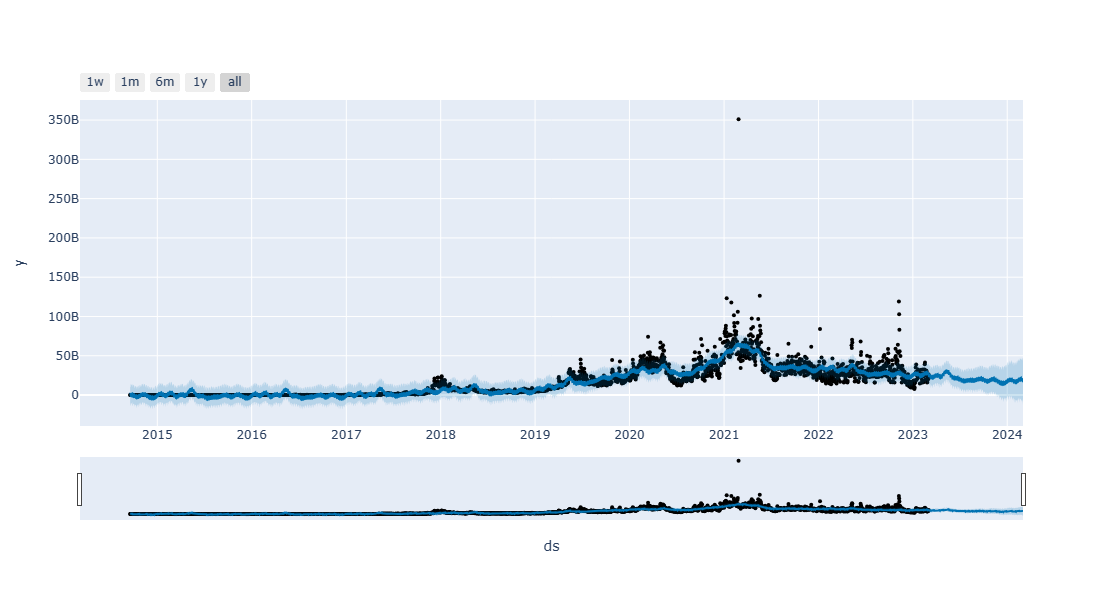

In [25]:
plot_plotly(m, forecast)

C:\Users\Sneha\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\Sneha\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\Sneha\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



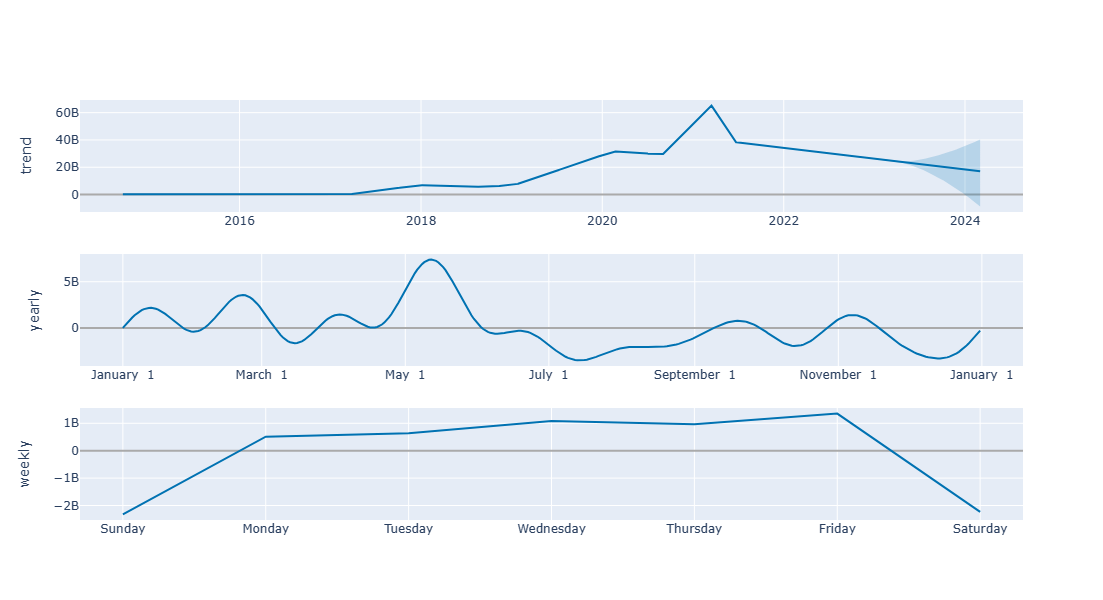

In [26]:
plot_components_plotly(m, forecast)

In [27]:
predictions = forecast.iloc[-365:]['yhat']

In [28]:
rmse = rmse(predictions,test['y'])
print("Root Mean Squared Error between actual and  predicted values: ",rmse)
print("Mean Value of Test Dataset:", test['y'].mean())


Root Mean Squared Error between actual and  predicted values:  10777146357.32089
Mean Value of Test Dataset: 18893783668.813698


In [29]:
max = fb['y'].max()
min = fb['y'].min()

In [30]:
nrmse = rmse/(max - min)
nrmse

0.030707442774472203

In [31]:
file_path = 'D:/Projects/Bitcoin Price Prediction/prophet_model.pkl'

In [32]:
pickle.dump(m, open(file_path, "wb"))